In [1]:
data_dir = "../input/heart-disease-dataset/proc_heart_cleve_3_withheader.csv"

from time import time
nb_start_time = time()

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#from time import time
import random as r

# Helper Functions

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")
    
def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()
    
def getCol(x):
    return [col for col in x.columns]

def getObj(x):
    s = (x.dtypes == "object")
    return list(s[s].index)

sc_X = StandardScaler()

# Data Handling

**Inputs**

In [4]:
data = pd.read_csv(data_dir)

breaker()
print("Dataset Shape :", repr(data.shape))
breaker()

for name in getCol(data):
    print(name)
breaker()


------------------------------

Dataset Shape : (299, 19)

------------------------------

Disease
Age
Sex
ind_typ_angina
ind_atyp_angina
ind_non_ang_pain
resting_BP
Serum_cholest
blood_sugar_exc120
ind_for_ecg_1
ind_for_ecg_2
Max_heart_rate
ind_exerc_angina
ST_dep_by_exerc
ind_for_slope_up_exerc
ind_for_slope_down_exerc
num_vessels_fluro
Thal_rev_defect
Thal_fixed_defect

------------------------------



**Preprocessing**

In [5]:
X = data.iloc[:, 1:].copy().values
y = data.iloc[:, 0].copy().values

#X = sc_X.fit_transform(X)

y[np.argwhere(y == -1)] = 0

num_features = X.shape[1]
num_obs_test = X.shape[0]

del data

**Dataset Template**

In [6]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
            
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [7]:
class CFG():
    tr_batch_size = 32
    ts_batch_size = 32
    va_batch_size = 32
    
    epochs = 50
    n_folds = 5
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    IL = num_features
    HL = [128]
    OL = 1
    
cfg = CFG()

simu_ts_data_setup = DS(X, None, "test")
simu_ts_data = DL(simu_ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

**Setup**

In [8]:
class MLP(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(MLP, this).__init__()
        
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        
        this.BN1 = nn.BatchNorm1d(IL)
        this.FC1 = WN(nn.Linear(IL, HL[0]))
        
        this.BN2 = nn.BatchNorm1d(HL[0])
        this.FC2 = WN(nn.Linear(HL[0], OL))
    
    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def forward(this, x):
        x = this.BN1(x)
        #x = this.DP1(x)
        x = F.relu(this.FC1(x))
        x = this.BN2(x)
        #x = this.DP2(x)
        x = torch.sigmoid(this.FC2(x))
        return x

**ANN Helpers**

In [9]:
def train_fn(X=None, y=None, n_folds=None):
    breaker()
    print("Training ...")
    breaker()
    
    fold = 0
    LP = []
    names = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    
    start_time = time()
    for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold} ...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        DLS = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
               "valid" : DL(va_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)
              }
        
        torch.manual_seed(0)
        model = MLP(cfg.IL, cfg.HL, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, eps=1e-6, verbose=True)
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feat, label in DLS[phase]:
                    feat, label = feat.to(cfg.device), label.to(cfg.device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feat)
                        loss   = nn.BCELoss()(output, label)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item() / label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            scheduler.step(epochLoss["valid"])
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "Model_Fold_{fold}.pt".format(fold=fold)
                names.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {f} folds for {e} epochs : {:.2f} seconds".format(time() - start_time, f=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()
    
    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs_test=None):
    y_pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        
        model.load_state_dict(torch.load(name))
        model.eval()
        
        for X in dataloader:
            X = X.to(cfg.device)
            with torch.no_grad():
                Prob = model(X)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[cfg.ts_batch_size:].cpu().numpy()
        y_pred = np.add(y_pred, Pred)
    y_pred = np.divide(y_pred, len(names))
    
    y_pred[np.argwhere(y_pred > 0.5)]  = 1
    y_pred[np.argwhere(y_pred <= 0.5)] = 0
    return y_pred

**Training and Evaluation**


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch    24: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Epoch    32: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
Epoch    33: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch    24: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5 ...
Epoch    15: reducing learning rate of group 0 to 1.0000e-04.
Epoch

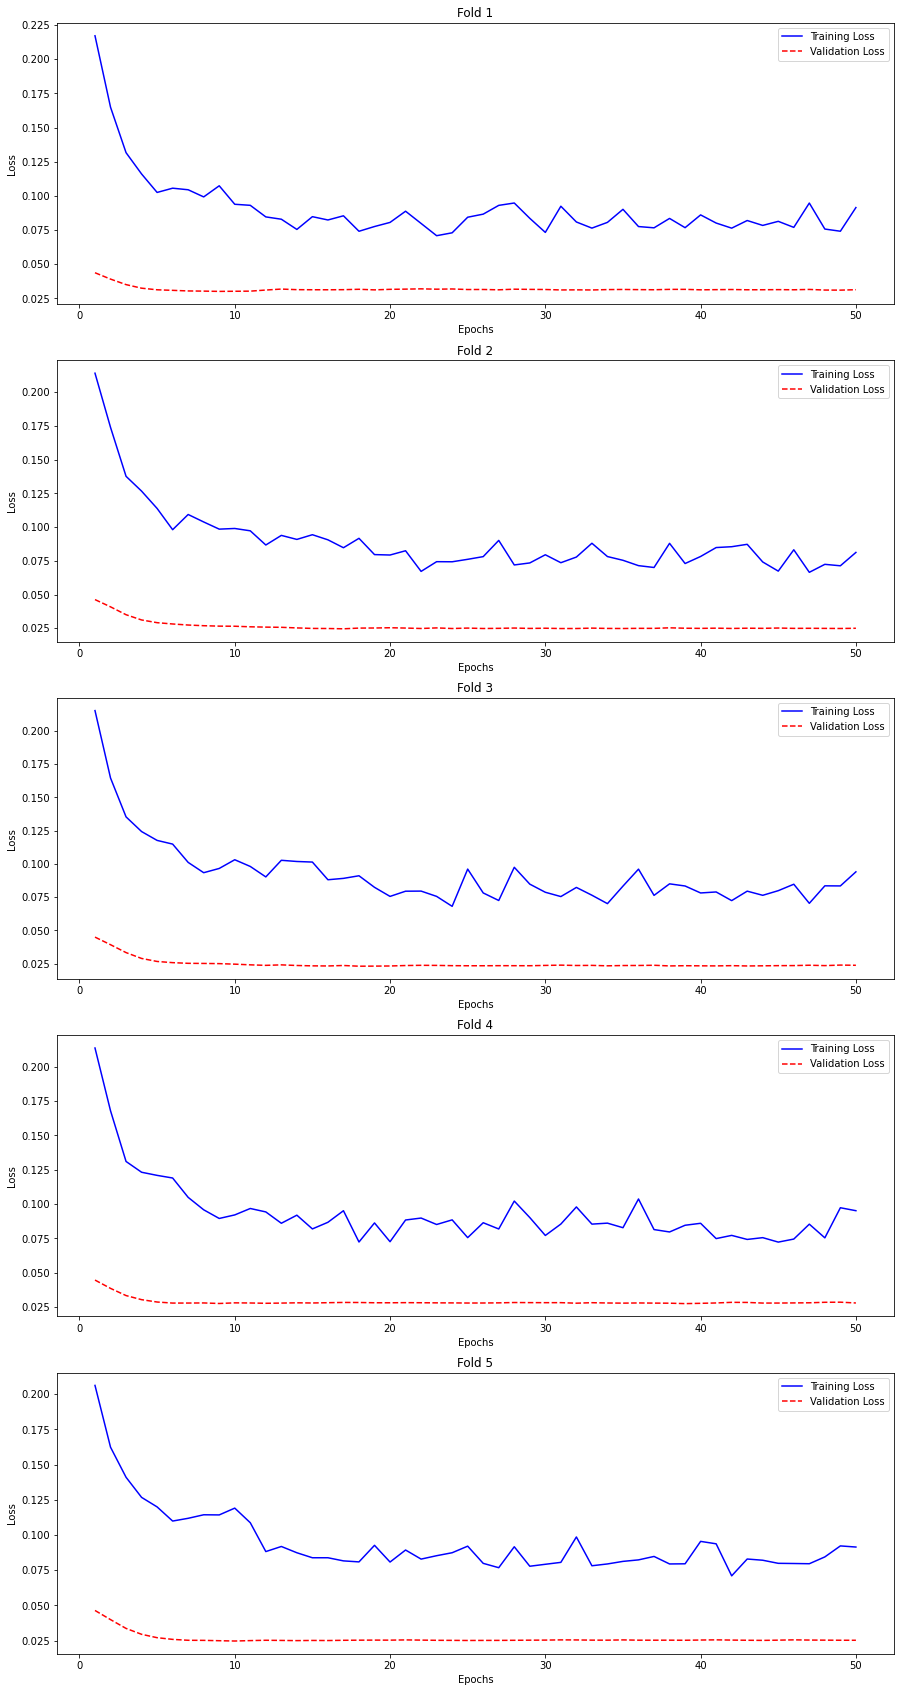

In [10]:
LP, Names, Network = train_fn(X=X, y=y, n_folds=cfg.n_folds)

y_pred = eval_fn(Network, set(Names), simu_ts_data, simu_ts_data_setup.__len__())

print("Accuracy : {:.5f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

In [11]:
breaker()
print("Notebook Runtime : {:.2f} seconds".format(time() - nb_start_time))
breaker()


------------------------------

Notebook Runtime : 13.85 seconds

------------------------------

